In [1]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
from interaction_inference import dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import tqdm

In [2]:
rng = np.random.default_rng()

# Interacting Birth-Death feasibility test

Optimizing on the downsampled scale it is now possible to test the feasibility of an 'interacting birth-death' model using joint probability constraints at low capture efficiency without time and memory scaling issues faced by the original scale methods.

We will use feasible data (sampled from the model) and infeasibile data (sampled from an interacting telegraph) to investigate the performance of the test

In [4]:
data = simulation.simulate_dataset_range_BD("data", [0, 1, 2, 3, 4, 5], rate=5, tqdm_disable=False)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:22<00:00,  3.77s/it]


In [5]:
beta = rng.beta(1, 2, size=1000)

In [6]:
data_downsampled = data.downsample("data_downsampled", beta)

In [7]:
data_downsampled.compute_fm(tqdm_disable=False)
data_downsampled.compute_moments(tqdm_disable=False)
data_downsampled.bootstrap_probabilities(tqdm_disable=False)

100%|██████████| 6/6 [00:00<00:00, 26.07it/s]


In [9]:
constraints = [
    "downsampled_probability",
    "downsampled_CME",
    "k_deg_1"
]

result = optimization.Optimization(data_downsampled, constraints, tqdm_disable=True)

Optimization status: OPTIMAL
Runtime: 0.017000198364257812
Optimization status: OPTIMAL
Runtime: 0.015000104904174805
Optimization status: OPTIMAL
Runtime: 0.01399993896484375
Optimization status: OPTIMAL
Runtime: 0.01399993896484375
Optimization status: OPTIMAL
Runtime: 0.0019998550415039062
Optimization status: OPTIMAL
Runtime: 0.004999876022338867


In [23]:
data_90 = simulation.simulate_dataset_range_TE("data_90", [0, 1, 2, 3, 4, 5], gene=0.9, rate=5, tqdm_disable=False)
data_50 = simulation.simulate_dataset_range_TE("data_50", [0, 1, 2, 3, 4, 5], gene=0.5, rate=5, tqdm_disable=False)
data_10 = simulation.simulate_dataset_range_TE("data_10", [0, 1, 2, 3, 4, 5], gene=0.1, rate=5, tqdm_disable=False)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


In [26]:
beta = rng.beta(1, 2, size=1000)

In [27]:
data_downsampled_90 = data_90.downsample("data_downsampled_90", beta)
data_downsampled_50 = data_50.downsample("data_downsampled_50", beta)
data_downsampled_10 = data_10.downsample("data_downsampled_10", beta)

In [29]:
data_downsampled_90.compute_fm(tqdm_disable=False)
data_downsampled_90.compute_moments(tqdm_disable=False)
data_downsampled_90.bootstrap_probabilities(tqdm_disable=False)
data_downsampled_50.compute_fm(tqdm_disable=False)
data_downsampled_50.compute_moments(tqdm_disable=False)
data_downsampled_50.bootstrap_probabilities(tqdm_disable=False)
data_downsampled_10.compute_fm(tqdm_disable=False)
data_downsampled_10.compute_moments(tqdm_disable=False)
data_downsampled_10.bootstrap_probabilities(tqdm_disable=False)

100%|██████████| 6/6 [00:00<00:00, 43.63it/s]


In [30]:
constraints = [
    "downsampled_probability",
    "downsampled_CME",
    "k_deg_1"
]

print(r"$k_{on}$ = 90%")

result_90 = optimization.Optimization(data_downsampled_90, constraints, tqdm_disable=True)

print(r"$k_{on}$ = 50%")

result_50 = optimization.Optimization(data_downsampled_50, constraints, tqdm_disable=True)

print(r"$k_{on}$ = 10%")

result_10 = optimization.Optimization(data_downsampled_10, constraints, tqdm_disable=True)

$k_{on}$ = 90%
Optimization status: OPTIMAL
Runtime: 0.03600001335144043
Optimization status: OPTIMAL
Runtime: 0.015000104904174805
Optimization status: OPTIMAL
Runtime: 0.013000011444091797
Optimization status: OPTIMAL
Runtime: 0.009999990463256836
Optimization status: OPTIMAL
Runtime: 0.008999824523925781
Optimization status: OPTIMAL
Runtime: 0.0009999275207519531
$k_{on}$ = 50%
Optimization status: OPTIMAL
Runtime: 0.24500012397766113
Optimization status: OPTIMAL
Runtime: 0.023999929428100586
Optimization status: OPTIMAL
Runtime: 0.017000198364257812
Optimization status: OPTIMAL
Runtime: 0.016000032424926758
Optimization status: OPTIMAL
Runtime: 0.016000032424926758
Optimization status: OPTIMAL
Runtime: 0.01399993896484375
$k_{on}$ = 10%
Optimization status: INFEASIBLE
Runtime: 0.04699993133544922
Optimization status: INFEASIBLE
Runtime: 0.10800004005432129
Optimization status: INFEASIBLE
Runtime: 0.3840000629425049
Optimization status: INFEASIBLE
Runtime: 0.22899985313415527
Optimi

## Gridtest

Look at a grid of capture efficiency and gene-on-rates to assess the performance of the feasibility test

Also investigate if interaction strength has an effect on performance: testing feasibility of a model that allows interaction, but interation in telegraph model could lead to data more / less similar to birth death data.

In [3]:
def simulate_dataset(name, gene_values, int_val=0.0, cells=1000, rate=1, runs=1, tqdm_disable=False):
    '''
    Custom dataset simulation
    '''

    # number of pairs
    gene_pairs = len(gene_values) * runs

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # sample counter
    i = 0

    # for each sample
    for gene_val in tqdm.tqdm(gene_values, disable=tqdm_disable):
        for k in range(runs):

            # Set reaction rate parameters
            k_on_1 = gene_val
            k_on_2 = gene_val
            k_off_1 = 1 - gene_val
            k_off_2 = 1 - gene_val
            k_tx_1 = rate
            k_tx_2 = rate
            k_deg_1 = 1
            k_deg_2 = 1
            k_reg = int_val

            # store parameters
            params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

            params = {
                'k_on_1': k_on_1,
                'k_on_2': k_on_2,
                'k_off_1': k_off_1,
                'k_off_2': k_off_2,
                'k_tx_1': k_tx_1,
                'k_tx_2': k_tx_2,
                'k_deg_1': k_deg_1,
                'k_deg_2': k_deg_2,
                'k_reg': k_reg
            }

            # simulate sample from model
            sample = simulation.gillespie_telegraph(params, cells)

            # store counts
            counts_df.iloc[i] = sample

            # increment sample
            i += 1

    # construct dataset object
    data = dataset.Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = gene_pairs
    data.beta = np.array([1.0 for j in range(cells)])

    return data

In [4]:
def simulate_downsampled(dataset, capture_values):
    '''
    Produce array of downsampled 'dataset' by each capture
    '''

    # downsampled dataset
    data_array = np.empty(len(capture_values), dtype=object)

    # for each capture
    for i, capture in enumerate(capture_values):

        # sample beta
        if capture == 0:
            beta = np.ones(dataset.cells)
        else:
            beta = rng.beta(1, capture, size=dataset.cells)

        # downsample dataset
        downsampled_dataset = dataset.downsample(
            f"dataset-{i}",
            beta
        )

        # store
        data_array[i] = downsampled_dataset

    return data_array

In [5]:
def test_array(data_array, capture_values, gene_values, runs):

    # result shape
    shape = (len(capture_values), len(gene_values))

    # result array
    results = np.zeros(shape)

    # for each downsampled dataset
    for j, data in enumerate(data_array):

        # compute moments
        data.compute_fm(tqdm_disable=True)
        data.bootstrap_probabilities(tqdm_disable=True)

        # run moment test
        momt = optimization.Optimization(
            data,
            [
                "downsampled_probability",
                "downsampled_CME",
                "k_deg_1"
            ],
            license_file="C:/WLS_credentials.json",
            tqdm_disable=False,
            print_solution=False
        )

        # sample counter
        i = 0

        # for each result
        for k, _ in enumerate(gene_values):
            for l in range(runs):

                # get result
                if momt.result_dict[i]['status'] == "INFEASIBLE":
                    results[j, k] += 1 / runs

                # increment counter
                i += 1

    return results

In [6]:
def indep_array(data_array, capture_values, gene_values, runs):

    # result shape
    shape = (len(capture_values), len(gene_values))

    # result array
    results = np.zeros(shape)

    # for each downsampled dataset
    for j, data in enumerate(data_array):

        # compute moments
        data.compute_fm(tqdm_disable=True)
        data.bootstrap_probabilities(tqdm_disable=True)

        # run moment test
        momt = optimization.Optimization(
            data,
            [
                "downsampled_probability",
                "downsampled_CME",
                "k_deg_1",
                "k_deg_2",
                "k_reg"
            ],
            license_file="C:/WLS_credentials.json",
            tqdm_disable=False,
            print_solution=False
        )

        # sample counter
        i = 0

        # for each result
        for k, _ in enumerate(gene_values):
            for l in range(runs):

                # get result
                if momt.result_dict[i]['status'] == "INFEASIBLE":
                    results[j, k] += 1 / runs

                # increment counter
                i += 1

    return results

In [ ]:
def marginal_array(data_array, capture_values, gene_values, runs):

    # result shape
    shape = (len(capture_values), len(gene_values))

    # result array
    results = np.zeros(shape)

    # for each downsampled dataset
    for j, data in enumerate(data_array):

        # compute moments
        data.compute_fm(tqdm_disable=True)
        data.bootstrap_probabilities(tqdm_disable=True)

        # run moment test
        momt = optimization.Optimization(
            data,
            [
                "downsampled_marginal_probability_1",
                "downsampled_marginal_probability_2",
                "downsampled_marginal_CME_1",
                "downsampled_marginal_CME_2",
                "k_deg_1",
                "k_deg_2"
            ],
            license_file="C:/WLS_credentials.json",
            tqdm_disable=False,
            print_solution=False
        )

        # sample counter
        i = 0

        # for each result
        for k, _ in enumerate(gene_values):
            for l in range(runs):

                # get result
                if momt.result_dict[i]['status'] == "INFEASIBLE":
                    results[j, k] += 1 / runs

                # increment counter
                i += 1

    return results

In [7]:
# settings
capture_values = [0, 1, 2, 3, 4, 5, 8, 10, 12, 14, 16, 18, 20]
gene_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
runs = 10
rate = 5

In [ ]:
data_0 = simulate_dataset("dataset-00", gene_values, int_val=0.0, cells=1000, rate=rate, runs=runs)

100%|██████████| 10/10 [04:02<00:00, 24.20s/it]


In [8]:
data_5 = simulate_dataset("dataset-05", gene_values, int_val=5.0, cells=1000, rate=rate, runs=runs)

100%|██████████| 10/10 [05:14<00:00, 31.49s/it]


In [8]:
data_array_0 = simulate_downsampled(data_0, capture_values)

In [9]:
data_array_5 = simulate_downsampled(data_5, capture_values)

In [9]:
test_0 = test_array(data_array_0, capture_values, gene_values, runs)

100%|██████████| 100/100 [00:02<00:00, 40.02it/s]


In [16]:
test_5 = test_array(data_array_5, capture_values, gene_values, runs)

100%|██████████| 100/100 [00:01<00:00, 56.79it/s]


In [10]:
indep_5 = indep_array(data_array_5, capture_values, gene_values, runs)

100%|██████████| 100/100 [00:02<00:00, 47.73it/s]

Optimization failed


In [17]:
marginal_5 = marginal_array(data_array_5, capture_values, gene_values, runs)

 11%|█         | 11/100 [00:00<00:01, 48.53it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 17%|█▋        | 17/100 [00:00<00:01, 51.40it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 23%|██▎       | 23/100 [00:00<00:01, 50.12it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 35%|███▌      | 35/100 [00:00<00:01, 43.60it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 47%|████▋     | 47/100 [00:00<00:01, 49.76it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 59%|█████▉    | 59/100 [00:01<00:00, 52.66it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 72%|███████▏  | 72/100 [00:01<00:00, 56.49it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 90%|█████████ | 90/100 [00:01<00:00, 55.24it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:01<00:00, 51.21it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed



 13%|█▎        | 13/100 [00:00<00:01, 61.86it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 20%|██        | 20/100 [00:00<00:01, 60.92it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 34%|███▍      | 34/100 [00:00<00:01, 60.30it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 48%|████▊     | 48/100 [00:00<00:00, 60.28it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 62%|██████▏   | 62/100 [00:01<00:00, 60.37it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 76%|███████▌  | 76/100 [00:01<00:00, 60.34it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 90%|█████████ | 90/100 [00:01<00:00, 60.35it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:01<00:00, 60.05it/s]


Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


  6%|▌         | 6/100 [00:00<00:01, 53.64it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 18%|█▊        | 18/100 [00:00<00:01, 50.27it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 30%|███       | 30/100 [00:00<00:01, 49.84it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 43%|████▎     | 43/100 [00:00<00:01, 55.77it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 50%|█████     | 50/100 [00:00<00:01, 49.80it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 63%|██████▎   | 63/100 [00:01<00:00, 53.31it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 76%|███████▌  | 76/100 [00:01<00:00, 56.17it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 89%|████████▉ | 89/100 [00:01<00:00, 57.75it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:01<00:00, 54.27it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed



 12%|█▏        | 12/100 [00:00<00:01, 55.82it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 25%|██▌       | 25/100 [00:00<00:01, 58.99it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 31%|███       | 31/100 [00:00<00:01, 49.49it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 43%|████▎     | 43/100 [00:00<00:01, 49.76it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 56%|█████▌    | 56/100 [00:01<00:00, 54.99it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 63%|██████▎   | 63/100 [00:01<00:00, 56.77it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 75%|███████▌  | 75/100 [00:01<00:00, 51.00it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 88%|████████▊ | 88/100 [00:01<00:00, 55.01it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:01<00:00, 53.02it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed



  2%|▏         | 2/100 [00:00<00:19,  5.13it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 16%|█▌        | 16/100 [00:00<00:02, 36.02it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 29%|██▉       | 29/100 [00:00<00:01, 48.53it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 42%|████▏     | 42/100 [00:01<00:01, 54.51it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 55%|█████▌    | 55/100 [00:01<00:00, 57.74it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 69%|██████▉   | 69/100 [00:01<00:00, 61.04it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 83%|████████▎ | 83/100 [00:01<00:00, 60.79it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 97%|█████████▋| 97/100 [00:01<00:00, 59.67it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 49.55it/s]


Optimization failed


  4%|▍         | 4/100 [00:00<00:02, 33.00it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 17%|█▋        | 17/100 [00:00<00:01, 45.53it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 29%|██▉       | 29/100 [00:00<00:01, 50.49it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 41%|████      | 41/100 [00:00<00:01, 48.49it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 52%|█████▏    | 52/100 [00:01<00:00, 49.77it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 64%|██████▍   | 64/100 [00:01<00:00, 48.96it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 75%|███████▌  | 75/100 [00:01<00:00, 47.70it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 87%|████████▋ | 87/100 [00:01<00:00, 51.40it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 93%|█████████▎| 93/100 [00:01<00:00, 51.15it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 49.39it/s]


Optimization failed


  6%|▌         | 6/100 [00:00<00:01, 52.31it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 18%|█▊        | 18/100 [00:00<00:01, 49.01it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 30%|███       | 30/100 [00:00<00:01, 53.20it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 43%|████▎     | 43/100 [00:00<00:01, 51.11it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 49%|████▉     | 49/100 [00:00<00:01, 49.44it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 60%|██████    | 60/100 [00:01<00:00, 46.52it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 75%|███████▌  | 75/100 [00:01<00:00, 47.40it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 85%|████████▌ | 85/100 [00:01<00:00, 45.27it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 95%|█████████▌| 95/100 [00:02<00:00, 42.71it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 46.35it/s]


Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 11%|█         | 11/100 [00:00<00:01, 53.10it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 23%|██▎       | 23/100 [00:00<00:01, 51.33it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 35%|███▌      | 35/100 [00:00<00:01, 51.65it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 41%|████      | 41/100 [00:00<00:01, 53.04it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 53%|█████▎    | 53/100 [00:01<00:00, 51.43it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 65%|██████▌   | 65/100 [00:01<00:00, 49.35it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 77%|███████▋  | 77/100 [00:01<00:00, 52.10it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 89%|████████▉ | 89/100 [00:01<00:00, 50.79it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 95%|█████████▌| 95/100 [00:01<00:00, 44.71it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


  6%|▌         | 6/100 [00:00<00:01, 55.48it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 18%|█▊        | 18/100 [00:00<00:01, 48.98it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 29%|██▉       | 29/100 [00:00<00:01, 48.25it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 41%|████      | 41/100 [00:00<00:01, 49.96it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 53%|█████▎    | 53/100 [00:01<00:00, 50.42it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 59%|█████▉    | 59/100 [00:01<00:00, 48.78it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 69%|██████▉   | 69/100 [00:01<00:00, 49.11it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 80%|████████  | 80/100 [00:01<00:00, 49.58it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 92%|█████████▏| 92/100 [00:01<00:00, 48.68it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 48.69it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed



 10%|█         | 10/100 [00:00<00:01, 47.91it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 16%|█▌        | 16/100 [00:00<00:01, 49.64it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 26%|██▌       | 26/100 [00:00<00:01, 47.70it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 38%|███▊      | 38/100 [00:00<00:01, 51.61it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 50%|█████     | 50/100 [00:01<00:01, 49.73it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 57%|█████▋    | 57/100 [00:01<00:00, 47.90it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 67%|██████▋   | 67/100 [00:01<00:00, 42.17it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 78%|███████▊  | 78/100 [00:01<00:00, 45.85it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 91%|█████████ | 91/100 [00:01<00:00, 45.02it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 47.41it/s]


Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 11%|█         | 11/100 [00:00<00:01, 50.79it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 17%|█▋        | 17/100 [00:00<00:01, 51.05it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 29%|██▉       | 29/100 [00:00<00:01, 48.54it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 40%|████      | 40/100 [00:00<00:01, 49.77it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 50%|█████     | 50/100 [00:01<00:01, 46.09it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 63%|██████▎   | 63/100 [00:01<00:00, 51.20it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 75%|███████▌  | 75/100 [00:01<00:00, 51.24it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 81%|████████  | 81/100 [00:01<00:00, 50.01it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 92%|█████████▏| 92/100 [00:01<00:00, 46.36it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 48.95it/s]


Optimization failed
Optimization failed
Optimization failed


  5%|▌         | 5/100 [00:00<00:02, 44.17it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 16%|█▌        | 16/100 [00:00<00:01, 48.42it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 28%|██▊       | 28/100 [00:00<00:01, 48.91it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 38%|███▊      | 38/100 [00:00<00:01, 46.79it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 51%|█████     | 51/100 [00:01<00:00, 49.34it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 61%|██████    | 61/100 [00:01<00:00, 43.99it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 72%|███████▏  | 72/100 [00:01<00:00, 46.48it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 78%|███████▊  | 78/100 [00:01<00:00, 49.36it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 89%|████████▉ | 89/100 [00:01<00:00, 45.49it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 47.12it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed



  5%|▌         | 5/100 [00:00<00:02, 42.72it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 16%|█▌        | 16/100 [00:00<00:01, 45.82it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 26%|██▌       | 26/100 [00:00<00:01, 46.74it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 38%|███▊      | 38/100 [00:00<00:01, 48.17it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 43%|████▎     | 43/100 [00:00<00:01, 48.61it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 53%|█████▎    | 53/100 [00:01<00:01, 38.88it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 63%|██████▎   | 63/100 [00:01<00:00, 38.90it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 74%|███████▍  | 74/100 [00:01<00:00, 44.51it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


 86%|████████▌ | 86/100 [00:01<00:00, 46.96it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


100%|██████████| 100/100 [00:02<00:00, 45.11it/s]

Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


In [20]:
def plot(array, title, caption, capture_values, gene_values, figsize=(6, 6)):

    fig, axs = plt.subplots(figsize=figsize)

    #fig.suptitle("Infeasibility %")

    #plt.tight_layout()

    cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

    vmin, vmax = 0, 1

    img = axs.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel(r"Gene on rate $k_{on}$")
    axs.set_xticks(range(len(gene_values)))
    axs.set_xticklabels(gene_values)
    axs.set_ylabel("Capture b: Beta(1, b)")
    axs.set_yticks(range(len(capture_values)))
    axs.set_yticklabels(capture_values)
    axs.set_title(title)

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label(caption)

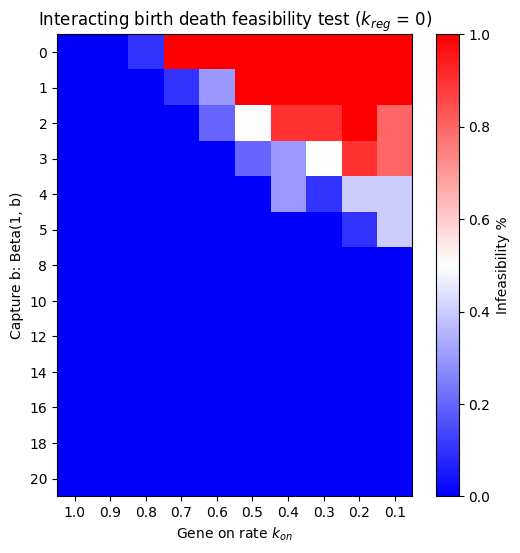

In [21]:
plot(test_0, r"Interacting birth death feasibility test ($k_{reg}$ = 0)", "Infeasibility %", capture_values, gene_values)

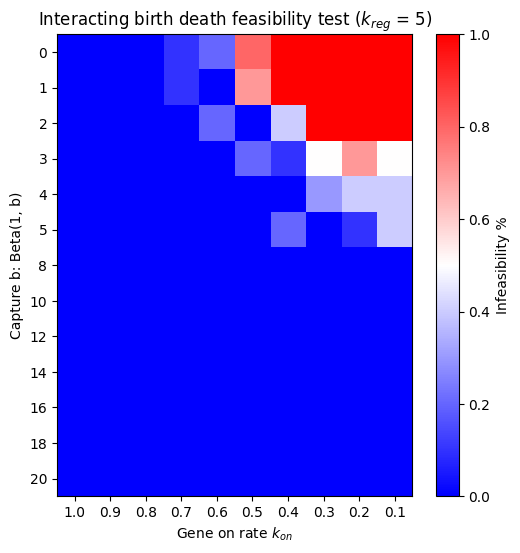

In [20]:
plot(test_5, r"Interacting birth death feasibility test ($k_{reg}$ = 5)", "Infeasibility %", capture_values, gene_values)

## Independent model

As an example, adding $k_{reg} = 0$ constraint easily turns the optimization into an independent birth-death model feasibility test, and we see that the performance is relatively consistent across telegraph data range but worsens as capture efficiency decreases.

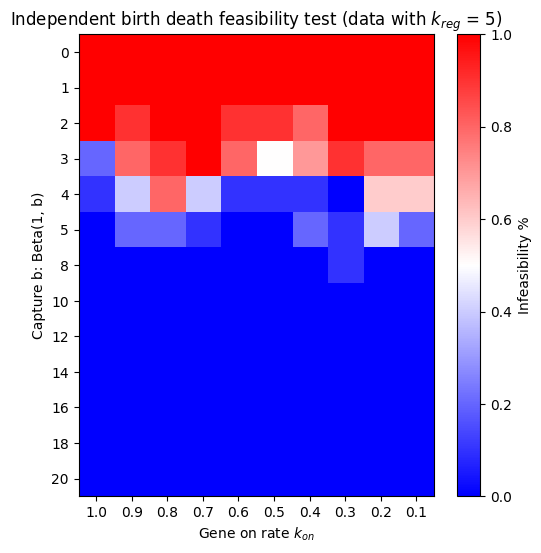

In [21]:
plot(indep_5, r"Independent birth death feasibility test (data with $k_{reg}$ = 5)", "Infeasibility %", capture_values, gene_values)

### Extra information

In [23]:
for b in capture_values:
    print(f"b = {b} | mean capture = {round(100 / (1 + b))}%")

b = 0 | mean capture = 100%
b = 1 | mean capture = 50%
b = 2 | mean capture = 33%
b = 3 | mean capture = 25%
b = 4 | mean capture = 20%
b = 5 | mean capture = 17%
b = 8 | mean capture = 11%
b = 10 | mean capture = 9%
b = 12 | mean capture = 8%
b = 14 | mean capture = 7%
b = 16 | mean capture = 6%
b = 18 | mean capture = 5%
b = 20 | mean capture = 5%


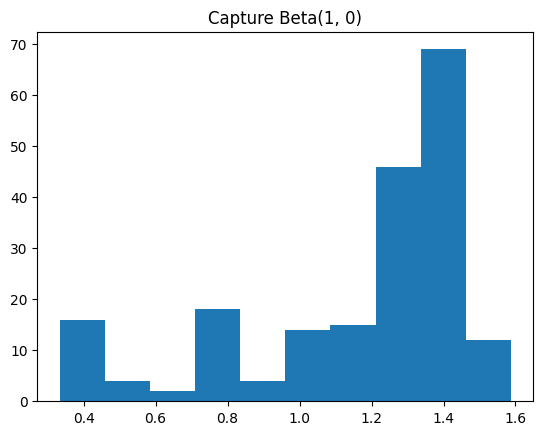

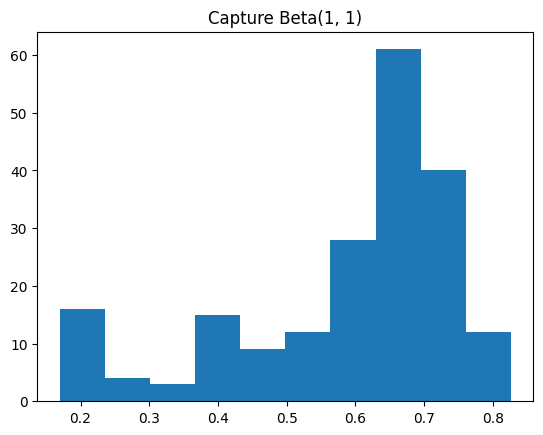

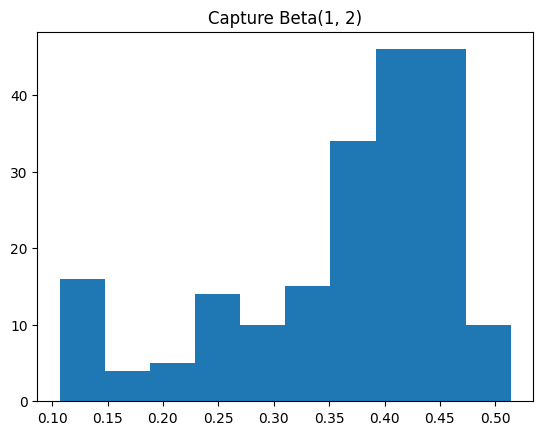

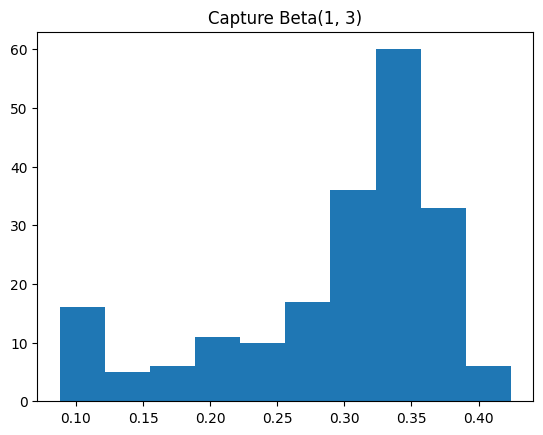

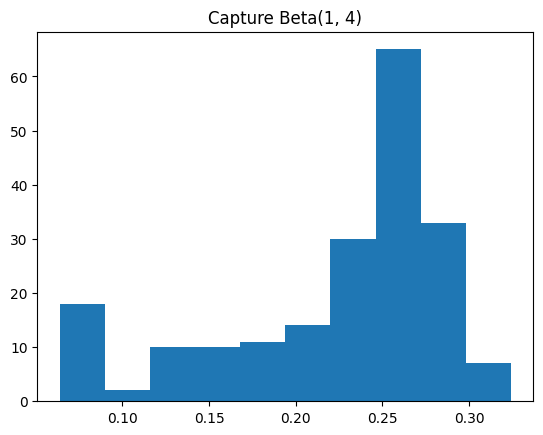

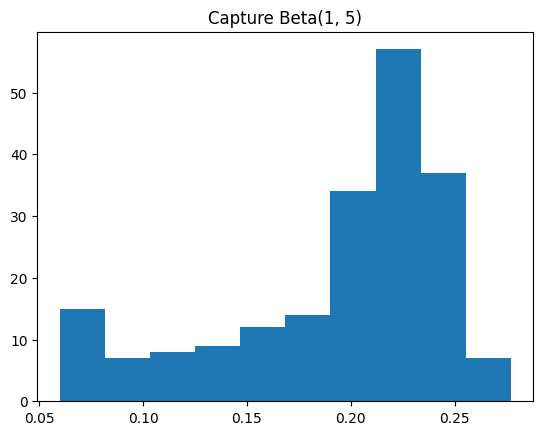

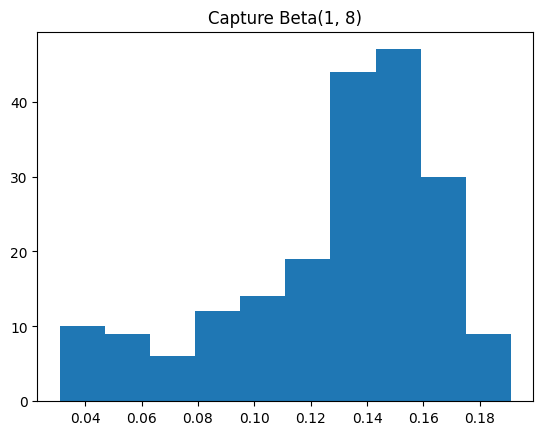

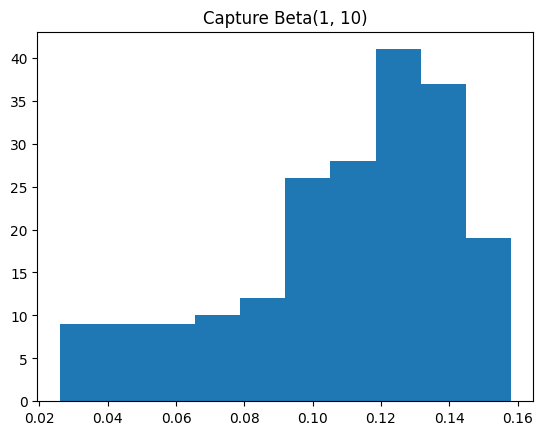

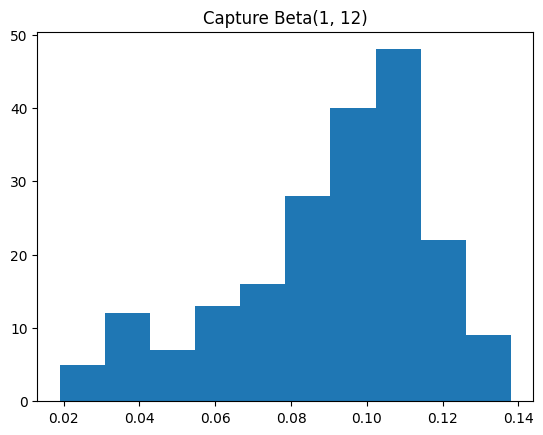

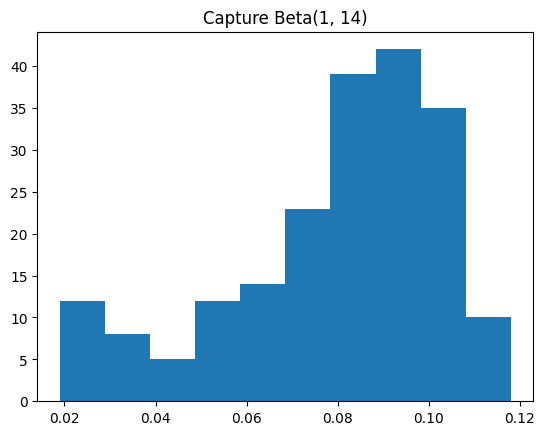

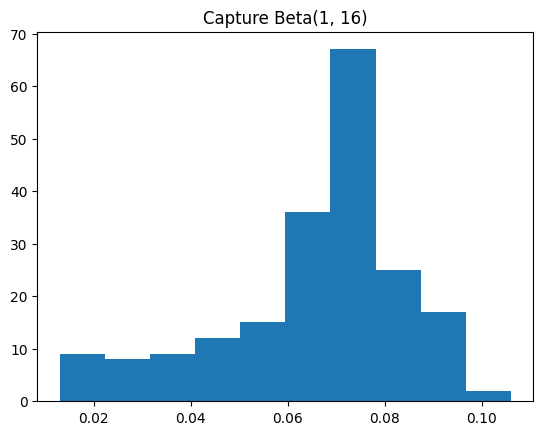

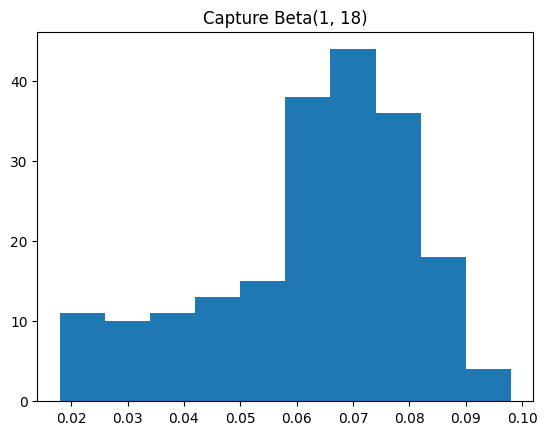

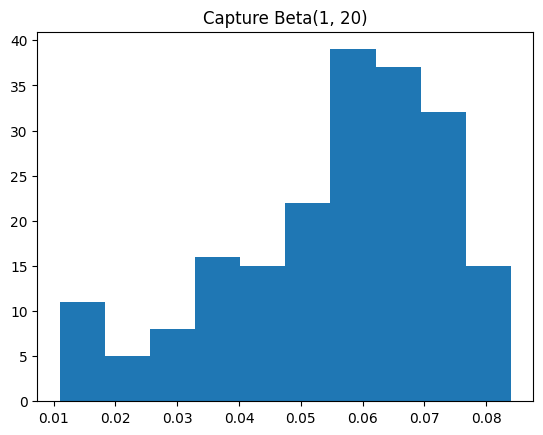

In [27]:
for j, b in enumerate(capture_values):
    b_means = []
    for i in range(100):
        sample = data_array_5[j].count_dataset.loc[f'Gene-pair-{i}']
        x1 = [x[0] for x in sample]
        x2 = [x[1] for x in sample]
        b_means += [float(np.mean(x1)), float(np.mean(x2))]
    plt.hist(b_means)
    plt.title(f"Capture Beta(1, {b})")
    plt.show()